Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in _notmist.ipynb_.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 2 to [0.0, 1.0, 0.0 ...], 3 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [75]:
# Cell author : Hoang NT
# Cell : Global variables, imports and helper functions

import math
import matplotlib.pyplot as plt
from IPython.display import display, Image
from scipy import ndimage

%matplotlib inline

IMAGE_SIZE = 28
IMAGE_PIXELS = IMAGE_SIZE * IMAGE_SIZE

def scale_dev(dsize) :
    return 1.0 / math.sqrt(float(dsize))

def randomize(dataset, labels) :
    perm = np.random.permutation(labels.shape[0])
    return dataset[perm], labels[perm]


---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [105]:
# Cell author : Hoang NT
# Cell : Logistic model with regularization

_alpha = 0.1 # Learning rate
_beta = 0.005 # Regularization factor
num_labels = 10
num_step = 8000
batch_size = 500
logis_scope = 'logistic'

# Quick flag
logis_train = True

# Build the computational graph
# Input:
### data_dataset - tf.placeholder - Input data for calculation
### num_labels - int - length of onehot label vector
# Output:
### logits - tf.Tensor - Result of computation
def logistic_inference(train_data) :
    # Weight matrix initialized as randomized matrix
    with tf.variable_scope(logis_scope) :
        weights = tf.get_variable('weights',
                                  dtype=tf.float32,
                                  initializer=tf.truncated_normal(
                                                [IMAGE_PIXELS, num_labels],
                                                stddev=scale_dev(IMAGE_PIXELS)))
        biases = tf.get_variable('biases', initializer=tf.zeros([num_labels]))
    logits = tf.matmul(train_data, weights) + biases
    return logits

# Add loss function with regularization term to the graph
# Input:
### logits - tf.Tensor - output node of inference
### labels - tf.placeholder - training labels to computute loss
### beta - float - regularization factor
# Output:
### loss - tf.Tensor - result node of loss computation
def logistic_loss(logits, labels, beta) :
    xentropy = tf.nn.softmax_cross_entropy_with_logits(logits, labels, name='xentropy')
    # Get weights node
    with tf.variable_scope(logis_scope) :
        tf.get_variable_scope().reuse_variables()
        weights = tf.get_variable('weights', [IMAGE_PIXELS, num_labels])
    loss_p = tf.reduce_mean(xentropy, name='mean_xentropy') 
    regu = tf.mul(beta,tf.nn.l2_loss(weights), name='regularization')
    loss = tf.add(loss_p, regu)
    return loss

# Create training operations with SGD optimizer
# Input:
### loss - tf.Tensor - loss function result node
### learning_rate - float - learning rate for SGD
# Output:
### train_op - tf.Tensor - operation node to run optimizer
def logistic_training(loss, learning_rate) :
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_op = optimizer.minimize(loss)
    return train_op

graph = tf.Graph()
with graph.as_default() :
    # Create placeholder for training data and labels
    tf_train_dataset = tf.placeholder(dtype=tf.float32, shape=[None, IMAGE_PIXELS])
    tf_train_labels = tf.placeholder(dtype=tf.float32, shape=[None, num_labels])
    # Add computational nodes to graph
    logits = logistic_inference(tf_train_dataset)
    loss = logistic_loss(logits, tf_train_labels, _beta)
    train_op = logistic_training(loss, _alpha)
    init = tf.initialize_all_variables()
    # Prediction output for each batch
    predictions_softmax = tf.nn.softmax(logits)
    with tf.Session() as session :
        session.run(init)
        for step in range(num_step) :
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Training data for each batch
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, 
                         tf_train_labels : batch_labels}
            _, l, predictions = session.run([train_op, loss, predictions_softmax],
                                           feed_dict = feed_dict)
            if (step % 500 == 0) :
                print("Minibatch loss at step %d: %f" % (step, l))
                print("Minibatch accuracy: %.1f%%" % accuracy(predictions,
                                                              batch_labels))
            if (step % 50 == 0) :
                randomize(train_dataset, train_labels)
        
        # Get weights for visualization
        with tf.variable_scope(logis_scope):
            tf.get_variable_scope().reuse_variables()
            weights = tf.get_variable('weights', [IMAGE_PIXELS, num_labels])
        
        # Validation step
        valid_dict = {tf_train_dataset : valid_dataset}
        predictions, np_weights = session.run([predictions_softmax, weights],
                                               feed_dict=valid_dict)
        print("Validation data loss: %f" % (l))
        print("Validation data accuracy: %.1f%%"
              % accuracy(predictions, valid_labels))
        
        

    

Minibatch loss at step 0: 2.391882
Minibatch accuracy: 8.2%
Minibatch loss at step 500: 0.677877
Minibatch accuracy: 81.6%
Minibatch loss at step 1000: 0.611340
Minibatch accuracy: 85.0%
Minibatch loss at step 1500: 0.691505
Minibatch accuracy: 81.4%
Minibatch loss at step 2000: 0.660924
Minibatch accuracy: 82.6%
Minibatch loss at step 2500: 0.665787
Minibatch accuracy: 84.0%
Minibatch loss at step 3000: 0.613281
Minibatch accuracy: 84.2%
Minibatch loss at step 3500: 0.672878
Minibatch accuracy: 83.8%
Minibatch loss at step 4000: 0.715981
Minibatch accuracy: 82.8%
Minibatch loss at step 4500: 0.671381
Minibatch accuracy: 82.8%
Minibatch loss at step 5000: 0.696467
Minibatch accuracy: 82.8%
Minibatch loss at step 5500: 0.605766
Minibatch accuracy: 83.0%
Minibatch loss at step 6000: 0.720161
Minibatch accuracy: 83.6%
Minibatch loss at step 6500: 0.614954
Minibatch accuracy: 84.8%
Minibatch loss at step 7000: 0.769754
Minibatch accuracy: 81.6%
Minibatch loss at step 7500: 0.670749
Minibat

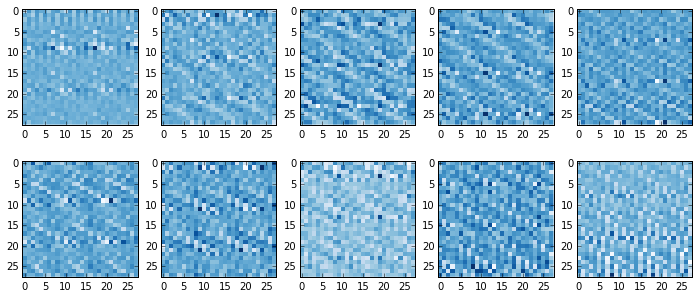

In [106]:
weights = np_weights.reshape((10,28,28))
plt.close('all')
plt.figure(figsize=(12,5))
plt.subplot(2,5,1)
plt.imshow(weights[0], cmap=plt.cm.Blues, interpolation='none') 
plt.subplot(2,5,2)
plt.imshow(weights[1], cmap=plt.cm.Blues, interpolation='none')
plt.subplot(2,5,3)
plt.imshow(weights[2], cmap=plt.cm.Blues, interpolation='none')
plt.subplot(2,5,4)
plt.imshow(weights[3], cmap=plt.cm.Blues, interpolation='none')
plt.subplot(2,5,5)
plt.imshow(weights[4], cmap=plt.cm.Blues, interpolation='none')
plt.subplot(2,5,6)
plt.imshow(weights[5], cmap=plt.cm.Blues, interpolation='none')
plt.subplot(2,5,7)
plt.imshow(weights[6], cmap=plt.cm.Blues, interpolation='none')
plt.subplot(2,5,8)
plt.imshow(weights[7], cmap=plt.cm.Blues, interpolation='none')
plt.subplot(2,5,9)
plt.imshow(weights[8], cmap=plt.cm.Blues, interpolation='none')
plt.subplot(2,5,10)
plt.imshow(weights[9], cmap=plt.cm.Blues, interpolation='none')

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [97]:
overfit_batch_num = 5
batch_size = 128
num_step = 10000

graph = tf.Graph()
with graph.as_default() :
    tf_train_dataset = tf.placeholder(dtype=tf.float32, shape=[None,IMAGE_PIXELS])
    tf_train_labels = tf.placeholder(dtype=tf.float32, shape=[None,num_labels])
    logits = logistic_inference(tf_train_dataset)
    loss = logistic_loss(logits, tf_train_labels, _beta)
    train_op = logistic_training(loss, _alpha)
    init = tf.initialize_all_variables()
    predictions_softmax = tf.nn.softmax(logits)
    with tf.Session() as sess :
        sess.run(init)
        for step in range(num_step) :
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Only use ~500 first sample
            if offset > 5 :
                offset = 0
            # Training data for each batch
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, 
                         tf_train_labels : batch_labels}
            _, l, predictions = sess.run([train_op, loss, predictions_softmax],
                                           feed_dict = feed_dict)
            if (step % 500 == 0) :
                print("Minibatch loss at step %d: %f" % (step, l))
                print("Minibatch accuracy: %.1f%%" % accuracy(predictions,
                                                              batch_labels))
        # Validation step
        valid_dict = {tf_train_dataset : valid_dataset}
        predictions = sess.run(predictions_softmax, feed_dict=valid_dict)
        print("Validation data accuracy: %.1f%%"
              % accuracy(predictions, valid_labels))
        
        # Get weights for visualization
        with tf.variable_scope(logis_scope):
            tf.get_variable_scope().reuse_variables()
            weights = tf.get_variable('weights', [IMAGE_PIXELS, num_labels])
        
        # Sanitized test dataset
        f = open('notMNIST_sanitized_test.pickle', 'rb')
        testsets = pickle.load(f)
        san_test_dataset, san_test_labels = reformat(testsets.get('test_dataset'), 
                                                     testsets.get('test_labels'))
        san_test_dict = {tf_train_dataset : san_test_dataset}
        predictions, np_weights = sess.run([predictions_softmax, weights]
                                           , feed_dict = san_test_dict)
        print("Sanitized test dataset accuracy: %.1f%%" 
             % accuracy(predictions, san_test_labels))

Minibatch loss at step 0: 2.416866
Minibatch accuracy: 8.6%
Minibatch loss at step 500: 0.111981
Minibatch accuracy: 100.0%
Minibatch loss at step 1000: 0.103732
Minibatch accuracy: 100.0%
Minibatch loss at step 1500: 0.100485
Minibatch accuracy: 100.0%
Minibatch loss at step 2000: 0.098622
Minibatch accuracy: 100.0%
Minibatch loss at step 2500: 0.097482
Minibatch accuracy: 100.0%
Minibatch loss at step 3000: 0.096764
Minibatch accuracy: 100.0%
Minibatch loss at step 3500: 0.096300
Minibatch accuracy: 100.0%
Minibatch loss at step 4000: 0.095989
Minibatch accuracy: 100.0%
Minibatch loss at step 4500: 0.095771
Minibatch accuracy: 100.0%
Minibatch loss at step 5000: 0.095613
Minibatch accuracy: 100.0%
Minibatch loss at step 5500: 0.095491
Minibatch accuracy: 100.0%
Minibatch loss at step 6000: 0.095394
Minibatch accuracy: 100.0%
Minibatch loss at step 6500: 0.095312
Minibatch accuracy: 100.0%
Minibatch loss at step 7000: 0.095241
Minibatch accuracy: 100.0%
Minibatch loss at step 7500: 0.

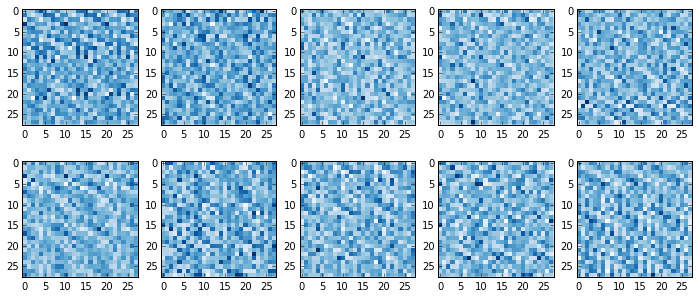

In [104]:
weights = np_weights.reshape((10,28,28))
plt.close('all')
plt.figure(figsize=(12,5))
plt.subplot(2,5,1)
plt.imshow(weights[0], cmap=plt.cm.Blues, interpolation='none') 
plt.subplot(2,5,2)
plt.imshow(weights[1], cmap=plt.cm.Blues, interpolation='none')
plt.subplot(2,5,3)
plt.imshow(weights[2], cmap=plt.cm.Blues, interpolation='none')
plt.subplot(2,5,4)
plt.imshow(weights[3], cmap=plt.cm.Blues, interpolation='none')
plt.subplot(2,5,5)
plt.imshow(weights[4], cmap=plt.cm.Blues, interpolation='none')
plt.subplot(2,5,6)
plt.imshow(weights[5], cmap=plt.cm.Blues, interpolation='none')
plt.subplot(2,5,7)
plt.imshow(weights[6], cmap=plt.cm.Blues, interpolation='none')
plt.subplot(2,5,8)
plt.imshow(weights[7], cmap=plt.cm.Blues, interpolation='none')
plt.subplot(2,5,9)
plt.imshow(weights[8], cmap=plt.cm.Blues, interpolation='none')
plt.subplot(2,5,10)
plt.imshow(weights[9], cmap=plt.cm.Blues, interpolation='none')

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---
